In [61]:
%matplotlib inline
import networkx as nx
import csv
import re
import pandas as pd
import numpy as np
import statistics
from statistics import StatisticsError
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics
from sklearn.decomposition import TruncatedSVD
import itertools
from sklearn import mixture




In [62]:
def L1 (x,y):
    dist = 0
    if len(x)==len(y):
        for i in range(len(x)):
            dist += math.fabs(x[i]-y[i])
        return(dist)
    else:
        print('vectors must be equal length for L1')
        return (None)


In [47]:
i = 0

with open('training.1600000.processed.noemoticon.csv') as f_in:
    for line in f_in:
        print (list(csv.reader(line, skipinitialspace=True)))
        print (line)
        i+=1
        if i>3:
            break

[['0'], ['', ''], ['1467810369'], ['', ''], ['Mon Apr 06 22:19:45 PDT 2009'], ['', ''], ['NO_QUERY'], ['', ''], ['_TheSpecialOne_'], ['', ''], ["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"], []]
"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

[['0'], ['', ''], ['1467810672'], ['', ''], ['Mon Apr 06 22:19:49 PDT 2009'], ['', ''], ['NO_QUERY'], ['', ''], ['scotthamilton'], ['', ''], ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"], []]
"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

[['0'], ['', ''], ['1467810917'], ['', ''], ['Mon Apr 06 22:19:53 PDT 2009'], ['', '

In [63]:
#!
# This code here makes the nx.Graph
G=nx.Graph()

m=0 # these two counters 
n=0 # arn't important

with open('training.1600000.processed.noemoticon.csv', encoding='latin-1') as f_in:
    for line in f_in: 
        lineX = list(csv.reader(line, skipinitialspace=True))
        G.add_node(lineX[8][0])
        if '@' in lineX[10][0]:
            m+=1
            for t in re.split('[^a-zA-Z\_\@]', lineX[10][0]):
                if t!='' and t[0]=='@' and t!='@':
                    G.add_edge(lineX[8][0],t[1:])
                    n+=1
        if n%100000==0:
            print(n)
print(nx.number_of_nodes(G))

#The lines are structured like below. Except csv.reader adds an extra ["",""]
#in between each of them. so multiply n by 2 for the first index.
"""
n | content
0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1 - the id of the tweet (2087)
2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
3 - the query. If there is no query, then this value is NO_QUERY.
4 - the user that tweeted
5 - the text of the tweet
"""
# this also works to read in the tweets, except that it makes it into a dataframe
# and reads it all at once.
"""
cols = ['polarity','tweetID','date','Query','UserID','text']
f_in = pd.read_csv('training.1600000.processed.noemoticon.csv',names=cols,encoding='latin-1')#names=m_cols ,

G=nx.Graph()
m=0
n=0

for index, row in f_in.iterrows():
    G.add_node(row[4])
    if '@' in row[5]:
        m+=1
        for t in re.split('[^a-zA-Z\_\@]', row[5]):
            if t!='' and t[0]=='@':
                G.add_edge(row[4],t[1:])
                n+=1
"""

100000
100000
100000
100000
100000
100000
100000
200000
200000
300000
300000
400000
500000
600000
700000
889334


In [20]:
print(nx.number_of_edges(G))

616462


In [21]:
nx.number_of_edges(G)/nx.number_of_nodes(G)

0.6931726437986179

In [22]:
# this is for making the graphs of degree distribution below
DegList = list(nx.degree(G).values())
DegDic = {}
for D in DegList:
    if D in DegDic:
        DegDic[D] += 1
    else:
        DegDic[D] = 1

(array([  8.89308000e+05,   1.50000000e+01,   7.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([    0.,   345.,   690.,  1035.,  1380.,  1725.,  2070.,  2415.,
         2760.,  3105.,  3450.]),
 <a list of 10 Patch objects>)

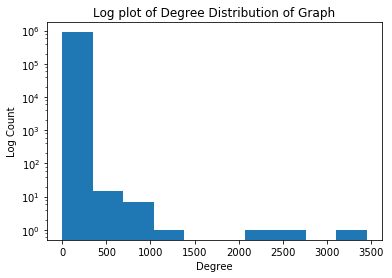

In [23]:
plt.yscale('log')
plt.ylabel('Log Count')
plt.title('Log plot of Degree Distribution of Graph')
plt.xscale('linear')
plt.xlabel('Degree')
plt.hist(DegList)

In [24]:
# miley got some people pissed off
DegList = list(nx.degree(G).items())
for D in DegList:
    if D[1]>3000:
        print(D)


('mileycyrus', 3450)


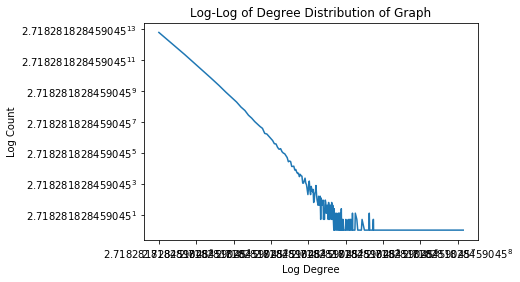

In [25]:
# she mentioned that if this is linear that the degrees follow a "power law"
plt.title('Log-Log of Degree Distribution of Graph')
plt.ylabel('Log Count')
plt.xlabel('Log Degree')
DegList = sorted(DegDic.items())
Xlist, Ylist = zip(*DegList)
plt.loglog(Xlist,Ylist, basex=np.e, basey=np.e)
del Xlist
del Ylist

In [27]:
# only did this for memory purposes
del DegDic
del DegList

In [64]:
#!
# Finding the largest connected_component
LargestCC = max(nx.connected_component_subgraphs(G), key=len) # largest connected component
print(nx.number_of_nodes(LargestCC))

339766


In [65]:
#!
# removes self-loops from the graph, this is needed to get nx.k_core
LargestCC.remove_edges_from(LargestCC.selfloop_edges())
scaler = MinMaxScaler((50,800))

In [53]:
# take a Long time to run,
# this is for the graph below
CoreCounts = []
for i in range(2,10):
    core_i = nx.k_core(LargestCC, i)
    CoreCounts.append(nx.number_of_nodes(core_i))
del core_i

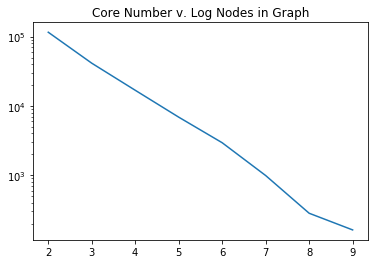

In [56]:
# This is not exactly Log nodes of graph
# the y-axis is nodes of graph, but is in log-scale

plt.title('Core Number v. Log Nodes in Graph')
plt.yscale('log')
plt.plot(range(2,10),CoreCounts)

In [66]:
#!
# I chose k_core k=7 because of the graph above,
# k=7 resulted in there being a good number of nodes
core7 = nx.k_core(LargestCC,7)

In [11]:
Bcent = np.array(list(nx.betweenness_centrality(core7,normalized = True).values()))
scaledBC = scaler.fit_transform(Bcent)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [12]:
Ecent = np.array(list(nx.eigenvector_centrality_numpy(core7).values()))
scaledEC = scaler.fit_transform(Ecent[:,np.newaxis])

In [ ]:
Ccent = np.array(list(nx.closeness_centrality(core7).values()))
scaledCC = scaler.fit_transform(Ccent[:,np.newaxis])

In [17]:
L1_dist = [L1(scaledCC,scaledBC),L1(scaledEC,scaledBC),L1(scaledEC,scaledCC)]
print("""From the three measures we have explored, Eigenvalue centality
Betweenness centality and Closeness centality. We can now evaluate the
L1 distance between the measures""")
D = L1_dist[0]
print("The L1 distance between Closeness centality and Betweenness Centrality is %d implying average distance of %f"%\
      (D, D*1.0/nx.number_of_nodes(core7)))
D = L1_dist[1]
print("The L1 distance between Eigenvalue centality and Betweenness Centrality is %d implying average distance of %f"%\
      (D, D*1.0/nx.number_of_nodes(core7)))
D = L1_dist[2]
print("The L1 distance between Closeness centality and Eigenvalue Centrality is %d implying average distance of %f"%\
      (D, D*1.0/nx.number_of_nodes(core7)))

From the three measures we have explored, Eigenvalue centality
Betweenness centality and Closeness centality. We can now evaluate the
L1 distance between the measures
The L1 distance between Closeness centality and Betweenness Centrality is 386829 implying average distance of 391.527373
The L1 distance between Eigenvalue centality and Betweenness Centrality is 45735 implying average distance of 46.290495
The L1 distance between Closeness centality and Eigenvalue Centrality is 371185 implying average distance of 375.693507


(array([ 929.,   19.,   23.,    5.,    6.,    2.,    2.,    0.,    1.,    1.]),
 array([  50.,  125.,  200.,  275.,  350.,  425.,  500.,  575.,  650.,
         725.,  800.]),
 <a list of 10 Patch objects>)

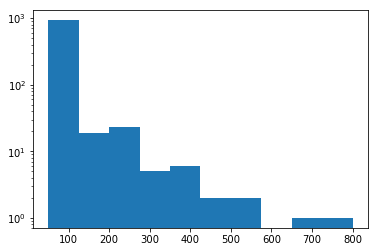

In [18]:
plt.yscale('log')
plt.hist(scaledBC)

(array([ 780.,  146.,   48.,    7.,    0.,    2.,    0.,    2.,    1.,    2.]),
 array([  50.,  125.,  200.,  275.,  350.,  425.,  500.,  575.,  650.,
         725.,  800.]),
 <a list of 10 Patch objects>)

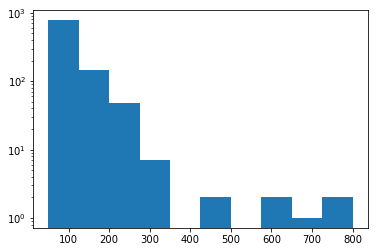

In [19]:
plt.yscale('log')
plt.hist(scaledEC)

(array([  11.,   29.,   31.,   57.,  175.,  252.,  332.,   71.,   21.,    9.]),
 array([  50.,  125.,  200.,  275.,  350.,  425.,  500.,  575.,  650.,
         725.,  800.]),
 <a list of 10 Patch objects>)

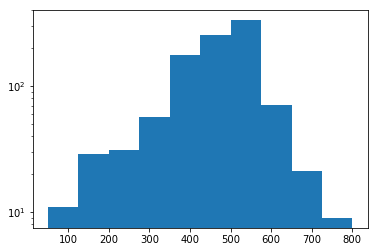

In [21]:
plt.yscale('log')
plt.hist(scaledCC)

In [63]:
# find the fiedler vector, and use it to partition the graph

f = nx.fiedler_vector(core7)
s = np.zeros(len(f),dtype='int')
s[f>0]=1

# this is the positions we will use for each graph
pos = nx.spring_layout(core7)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold i

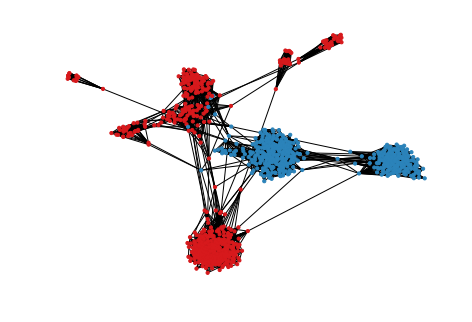

In [64]:
# draw partition
colors = ['#d7191c', '#2b83ba']
node_colors = [colors[s[v]] for v in range(nx.number_of_nodes(core7))]
nx.draw(core7,pos=pos, node_color=node_colors,node_size=10) # this uses the pos above
#nx.draw(core7, node_color=node_colors,node_size=10) original code for graph below

In [68]:
#!
# this makes the laplacian matrix to do the spectral clustering
L = nx.laplacian_matrix(core7).todense()
w, v = np.linalg.eig(L)
v = np.array(v)
worder = np.argsort(w)

X = v @ np.diag(w)
X = X[:,worder]

In [57]:
# takes a long time to run
# this makes the graph below
error = np.zeros(9)
for k in range(2,11):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(X[:,1:3])
    error[k-2] = kmeans.inertia_


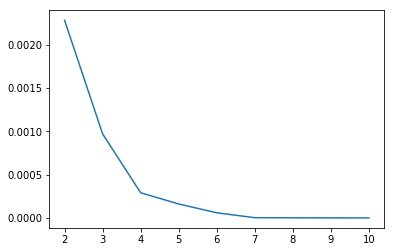

In [58]:
# graph of explained variance vs k (for k-means)
plt.plot(range(2,11),error)

In [70]:
# based on the graph above, k=6 was chosen. k=4 was what we were taught to
# choose, because it's the "L" in the graph. Though that didn't look good,
# so I increased k to 6.
# this runs k-means for the next code
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10)
kmeans.fit_predict(X[:,1:3])
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:382: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold i

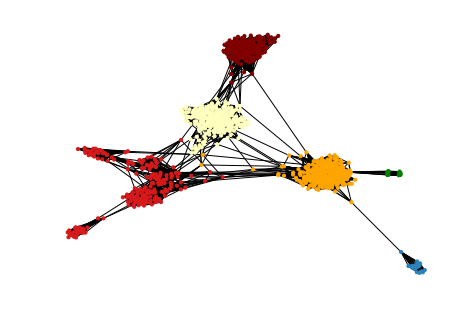

In [71]:
colors = ['#d7191c', '#ffffbf', '#2b83ba', 'green','orange','maroon']
node_colors = [colors[labels[i]] for i in range(nx.number_of_nodes(core7))]
nx.draw(core7, pos = pos, node_color=node_colors,node_size=10)

In [72]:
#!
# this reads in the tweets
# then simply parses user ID into ID_list
# and the tweet text into TextList
TextList = []
ID_list = []
n=0
with open('training.1600000.processed.noemoticon.csv', encoding='latin-1') as f_in:
    for line in f_in:
        lineX = list(csv.reader(line, skipinitialspace=True))
        TextList.append(lineX[10][0])
        ID_list.append(lineX[8][0])
        n=n+1
        if n%100000==0:
            print(n)
print(n)


100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1600000


In [4]:
#!
# vectorize TextList to dtm
vectorizer = TfidfVectorizer(stop_words='english', min_df=4,max_df=0.8)
dtm = vectorizer.fit_transform(TextList)
del TextList

In [5]:
#!
# compute svd of dtm
svd = TruncatedSVD(n_components=100, n_iter=4)
svdOutput = svd.fit_transform(dtm)

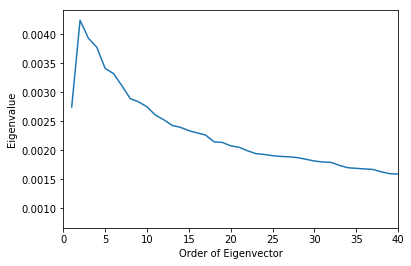

In [19]:
# I may be doing this part wrong, since it's weird
# to have that little peak at x=1. The graph should
# be strictly decreasing, according to another class
# I took
plt.xlim([0,40])
plt.plot(range(1,len(svd.explained_variance_)+1),svd.explained_variance_)
plt.xlabel('Order of Eigenvector')
plt.ylabel('Eigenvalue')

In [ ]:
# takes a long time to run
# results in a graph of explained variance
# vs k for k-means
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, max_iter=100, n_init=20)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
        print(k)
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

evaluate_clusters(svdOutput[:,:15],15)

In [17]:
#!
# this is the model I went with for LSA

gmm = mixture.GaussianMixture(n_components=5, covariance_type='full')
gmm.fit(svdOutput[:,:15])
pred = gmm.predict(svdOutput[:,:15])

AttributeError: 'GaussianMixture' object has no attribute 'labels_'

In [12]:
# I also did this model, except that it turned out
# that the largest cluster just dominated all the others
kmeans2 = KMeans(n_clusters=8, init='k-means++', n_init=20,random_state=0)
kmeans2.fit_predict(svdOutput[:,:15])
labels2 = kmeans2.labels_
print ("Finished")

Finished


In [19]:
# this converts the GMM result from classifying tweets
# into classifying users
ID_Pred = {}
for i in range(len(ID_list)):
    ID = ID_list[i]
    if ID in ID_Pred:
        ID_Pred[ID].append(pred[i])
    else:
        ID_Pred[ID]=[pred[i]]
        
colors = ['#d7191c', '#ffffbf', '#2b83ba', 'green','orange','maroon','black']
node_colors = []
for g in core7: # classify the nodes, based off their tweets
    try:
        try: # if there is only one mode of groups, classify the user as the mode
            X = statistics.mode(ID_Pred[g])
            node_colors.append(colors[X])
        except StatisticsError: # if there is no mode, pick a tweet at random, and classify the user as that tweet's group
            node_colors.append(colors[ID_Pred[g][random.randint(0,len(ID_Pred[g])-1)]])
            
    except KeyError: # if the node never tweeted (was only tweeted at)
        node_colors.append(colors[6]) # make it black

/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold i

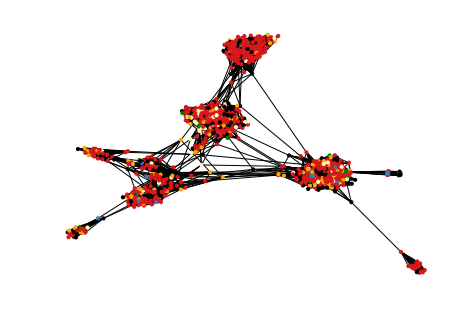

In [59]:
nx.draw(core7,pos=pos, node_color=node_colors,node_size=10)

In [ ]:
print(len(labels))

In [76]:
for i in range(0,100):
    print(pred[i],TextList[i])

2 @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
3 is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
0 @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
4 my whole body feels itchy and like its on fire 
0 @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
0 @Kwesidei not the whole crew 
4 Need a hug 
2 @LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?
0 @Tatiana_K nope they didn't have it 
0 @twittera que me muera ? 
0 spring break in plain city... it's snowing 
1 I just re-pierced my ears 
0 @caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .
0 @octolinz16 It it counts, idk why I did either. you never talk to me anymore 
4 @smarrison i would've been the first, but i

In [90]:
u, s, vt = np.linalg.svd(dtm,full_matrices=False)

for i in range(6):
    top = np.argsort(vt[i])
    topterms = [terms[top[0,f]] for f in range(12)]
    print (i, topterms)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [80]:
for i in range(100):
    if pred[i]==0:
        print (TextList[i])

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
@Kwesidei not the whole crew 
@Tatiana_K nope they didn't have it 
@twittera que me muera ? 
spring break in plain city... it's snowing 
@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .
@octolinz16 It it counts, idk why I did either. you never talk to me anymore 
Hollis' death scene will hurt me severely to watch on film  wry is directors cut not out now?
about to file taxes 
@LettyA ahh ive always wanted to see rent  love the soundtrack!!
@FakerPattyPattz Oh dear. Were you drinking out of the forgotten table drinks? 
@angry_barista I baked you a cake but I ated it 
I hate when I have to call and wake people up 
ooooh.... LOL  that leslie.... and ok I won't do it again so leslie won't  get mad again 
some1 hacked my account on aim  now i have

In [81]:
for i in range(100):
    if pred[i]==1:
        print (TextList[i])

I just re-pierced my ears 
@alydesigns i was out most of the day so didn't get much done 
blagh class at 8 tomorrow 
thought sleeping in was an option tomorrow but realizing that it now is not. evaluations in the morning and work in the afternoon! 
Falling asleep. Just heard about that Tracy girl's body being found. How sad  My heart breaks for that family.
Ugh....92 degrees tomorrow 
just leaving the parking lot of work! 
I had such a nice day. Too bad the rain comes in tomorrow at 5am 
@Starrbby too bad I won't be around I lost my job and can't even pay my phone bill lmao aw shucks 
Damm back to school tomorrow 
@katortiz  Not forever... See you soon!
had a blast at the Getty Villa, but hates that she's had a sore throat all day. It's just getting worse too 
A bad nite for the favorite teams: Astros and Spartans lose.  The nite out with T.W. was good.


In [82]:
for i in range(100):
    if pred[i]==2:
        print (TextList[i])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?
@julieebaby awe i love you too!!!! 1 am here  i miss you
@MissXu sorry! bed time came here (GMT+1)   http://is.gd/fNge
Broadband plan 'a massive broken promise' http://tinyurl.com/dcuc33 via www.diigo.com/~tautao Still waiting for broadband we are 
Why won't you show my location?!   http://twitpic.com/2y2es
Strider is a sick little puppy  http://apps.facebook.com/dogbook/profile/view/5248435


In [100]:
#!
# this gives the top terms of each eigenvector for our LSA
# the groups aren't exactly these values, but it's similar.
# you can also plot the nodes , with these eigenvectors as the axis
# being a good way to visualize the results of LSA
for i in range(0,10):
    top = np.argsort(svd.components_[i])
    topterms = [terms[top[f]] for f in range(30)]
    print()
    print (i, topterms)



0 ['hunggry', '302now', 'retwee', 'ctrld', 'housamz', 'øªø¹ù', 'lesnoy_chelovek', '¼í', 'laptopless', 'arturclancy', 'shoohurt', 'city_realist', 'mountain_diu', 'magicasland', 'afonin', 'mironset', 'all_lies_about', 'ðºð¾ð¼ñ', 'verysmallghost', 'rounddancer', 'ø²ù', 'beregulina', 'ð¼ð¾ð¹', 'lukashevich', '½rlich', 'dchest', 'ð¹ð½ñ', 'inviat', 'nomoretears', 'ºà']

1 ['work', 'good', 'day', 'morning', 'today', 'going', 'night', 'tomorrow', 'home', 'sleep', 'bed', 'time', 'tired', 'hope', 'ready', 'luck', 'school', 'weekend', 'getting', 'feel', 'early', 'feeling', 'long', 'week', 'sick', 'tonight', 'hours', 'great', 'happy', 'having']

2 ['work', 'just', 'going', 'want', 'quot', 'got', 'don', 'home', 'tomorrow', 'today', 'ready', 'im', 'know', 'getting', 'miss', 'wanna', 'like', 'tired', 'time', 'need', 'bored', 'think', 'hours', 'bed', 'sad', 'really', 'tonight', 'sick', 'school', 'hate']

3 ['work', 'http', 'com', 'day', 'twitpic', 'good', 'morning', 'today', 'plurk', 'tomorrow', 'tin

In [93]:
terms = vectorizer.get_feature_names()


In [ ]:
# Stuff that never got used
def CompareClustering(Clust1, Clust2, NumberOfClusters):
    length = len(Clust2)
    Factorial = math.factorial(NumberOfClusters)
    Results = [0]*Factorial
    Comp = itertools.permutations(range(NumberOfClusters),NumberOfClusters)
    if len(Clust1)==length:
        for i in range(length):
            for m in range(Factorial):
                if Clust1[i] == Comp[m][Clust2[i]]:
                    Results[m] +=1
        return (max(Results),length)
    else:
        print('error: wrong length cluster')
        return(None)

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=8, max_df=0.8)
dtm = vectorizer.fit_transform(TextList)

del TextList
terms = vectorizer.get_feature_names()
print("Finished")